In [16]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import matplotlib.pyplot as plt

mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
sess = tf.InteractiveSession()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


定义两个函数，分别用于产生卷积神经网络的参数W（卷积核），b（偏置）
+ **weight_variable**
+ **bias_variable**

这两个函数没什么可说的，很简单的创建Variable对象的代码，需要注意一点的是，在创建W参数的时候使用的是**tf.truncated_normal**这个和普通的正态分布不太一样，这是一个截断的产生正太分布的函数，就是说产生正太分布的值如果与均值的差值大于两倍的标准差，那就重新生成。和一般的正太分布的产生随机数据比起来，这个函数产生的随机数与均值的差距不会超过两倍的标准差。

同时，因为使用ReLU，给偏置增加一些小的正值（0.1），用来避免死亡节点

In [19]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape) :
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

接下来定义卷积层和池化层的函数。
+ **conv2d（卷积层）**
 卷积层我们需要两个参数，一个是卷积层的输入数据x，一个是卷积核。之后我们使用tensorflow中带有的卷积操作来完成卷积层的操作。这里的W和x不用说了，这里的strides是卷积核移动的步长，这里的定义分别是 **[batch_size_tride, weight_tride, height_tride, channel_tride]**, 一般来说，batch_size_tride，和channel_tride都是不用改变的，都是1，因为我们不太会想跳过某些图片或者某些channel。我们唯一想改变的是输出图像的大小维度，因此改变weight_tride和height_tride可以达到这个目的。而**Padding=SAME** 是为了填充输入图像，让输出图像和输入图像的维度一致

+ **max_pool_2x2（池化层）**
 这里的池化层也是使用了tensorflow里面的操作，这里需要定义一个**ksize**和**strides**，这里的ksize是指用于池化层的核的大小。strides不用再赘述了

In [20]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

这里定义几个占位符，首先肯定是输入x，第二个就是实际的网络输出y_.

因为我们的x是一维的数据信息，而我们的卷积神经网络是处理二维的图片信息，这里我们把一维的信息**reshape**成二维的图片信息，而我们知道我们的手写图片的像素信息是28\*28像素的,因此把它转换为 **[batch-size, width, height, channel]** 的图片信息，这里的batch-size = -1，是代表样本的数量不固定。之后我们会使用reshape后的二维图像信息**x_image**作为卷积神经网络的输入。

In [21]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])
x_image = tf.reshape(x, [-1, 28, 28, 1])

初始化第一层卷积层的参数以及计算
W_conv1的初始化这里的参数说明[5,5,1,32]表示，卷积核的大小为5\*5，上一层的channel数（颜色通道数）为1，总共有32个卷积核。因此**总共参数有5\*5\*32 + 32 = 832个**。
b_conv1的初始化就不说了，它只需要保证数量和W_conv1相同即可，剩下的工作交给python的广播去做就可以了。

之后对卷积核W_conv1和输入x_image做卷积操作然后加上偏置b_conv1,之后应用ReLU激活函数即可得到卷积层的输出。

然后在对前面卷积层的输出应用池化层获得输出，这样，卷积神经网络的第一层就定义完了。

在经过第一层处理之后，网络的**输出维度为[batch-size, 14, 14, 32]**

In [22]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

第二层和第一层的情况类似，不同的是W的定义上，因为上一层的通道数为32，因此相应W参数定义的时候通道数那里的参数也应该定义为32，同时卷积核的数量变为了64个。之后同样应用ReLU激活函数，以及最大池化层。

**这一层的参数有5\*5\*64 + 64 = 1664个**

经过第二层处理后，图像的**输出维度为[batch-size, 7, 7, 64]**

In [23]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

接下来定义**全连接层**,全连接层会拿之前的第二层的池化层的全部输出作为输入，结构类似于全连接神经网络，因此，在这里我们需要把之前的二维图像信息再转化为一维信息，因此，上一层的输入总共有7\*7\*64个，而第一个全连接层我们准备有1024个网络节点，因此这里**W参数的维度为[7*7*64, 1024]**,这里的输入救赎我们第二层的池化层的输出的reshape，也就是我们这里的**h_pool2_fat**,激活函数我们同样运用ReLU函数。

因此，这一层的**参数总数为 7\*7\*64\*1024 + 1024 = 3212288**

经过这个全连接层之后，**网络的输出为[batch-size, 1024]**

In [24]:
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_fat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_fat, W_fc1) + b_fc1)

之后，我们对第一个全连接层运用dropout算法，是为了运用正则化，让神经网络对数据有更好的泛化性。输出为**h_fc1_drop**

In [25]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob=keep_prob)

我们定义第二层的全连接层，这一层就作为我们的输出，因此这一层总共有10个节点，分别对应我们最终的输出。
因此**这一层的参数总共有1024\*10+10=10250**

因为要做最后的预测，所以我们对这一层的激活函数采用**softmax**激活函数

经过第二层全连接层之后，**最终我们的网络输出维度为[batch-size, 10]**

In [26]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

定义损失函数以及定义训练器，这里采用Adam算法。
损失函数的公式我直接写在下面：
$$H_{y^{'}}(y)=-\sum_{i}y_{i}^{'}log(y_{i})$$

> 对于我们上面定义的卷积神经网络，它总共的参数个数如下：832+1664+3212288+10252=3225036，三百二十二万的参数，而且我们发现，绝大部分的参数都集中在全连接层，将近占了总网络参数的99.923%。

In [27]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

验证正确率公式

In [28]:
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.arg_max(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

初始化网络参数

In [29]:
tf.global_variables_initializer().run()

进行训练，训练20000次，而且每隔一百次，我们就用训练集的batch数据去保存一次正确率，最后我们绘制出来卷积神经网络正确率变化的曲线。

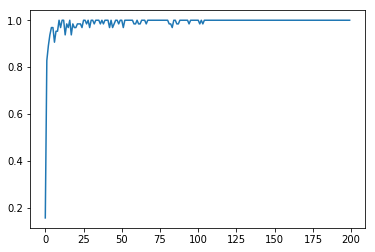

In [30]:
accuracy_list = []
for i in range(20000):
    batch_xs, batch_ys = mnist.train.next_batch(64)
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict = {x:batch_xs, y_:batch_ys, keep_prob:1.0})
        accuracy_list.append(train_accuracy)
    train_step.run(feed_dict={x:batch_xs, y_:batch_ys, keep_prob:0.5})
plt.plot(accuracy_list)
plt.show()

In [32]:
print("test accuracy %g"%accuracy.eval(feed_dict = {x:mnist.test.images, y_:mnist.test.labels, keep_prob:1.0}))

test accuracy 0.9918


我没想到，最终的正确率能达到**99.18%**,这充分的证明了，卷积神经网络对我们的计算机视觉来说，识别正确率要远远高于全连接神经网络。而根据上面的正确率变化曲线来看，这已经是我们这个网络的极限了，当然，如果我们调整里面的某些参数，以及再应用某些优化算法应该还可以让正确率再稍微提高一些。

In [34]:
sess.close()